# Graph Analysis of Budapest Reference Connectome 3.0

This notebook contains basic analysis of the properties of the brain connectivity graph from the [Budapest Reference Connectome](https://pitgroup.org/connectome/), a consensus brain graph summarizing the connectomes of 477 people using MRI data from the Human Connectome Project.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import bct

## Load Data

In [2]:
df = pd.read_csv("budapest_connectome_3.0_5_0_median.csv", sep=";")
print(df.iloc[0])

id node1                                        559
id node2                                        559
name node1               lh.rostralmiddlefrontal_15
name node2               lh.rostralmiddlefrontal_15
parent id node1                                  48
parent id node2                                  48
parent name node1       ctx-lh-rostralmiddlefrontal
parent name node2       ctx-lh-rostralmiddlefrontal
edge confidence                                 112
edge weight(med nof)                            4.0
Name: 0, dtype: object


The dataset represents a weighted, undirected graph constructed from the unified connectomes of 477 participants. Because diffusion MRI measures the movement of water molecules rather than electrical signaling, the data does not provide information about neural directionality (axon to dendrite). As a result, connections are modeled as undirected edges between brain regions.

Each node corresponds to a brain region, while the term “parent region” refers to a broader anatomical structure that a node belongs to (for example, a cortical lobe).

A track is a reconstructed pathway between two regions produced by tractography algorithms. These tracks form the basis for determining whether regions are structurally connected.

Edge confidence represents the number of subjects (out of 477) in which a connection appears. This serves as a measure of reliability and reproducibility across the subject population.

Edge Weight
Edge weight is computed as `n / L`, where:

• n = number of reconstructed tracks between two regions

• L = average length of those tracks

This formulation approximates connection density since high weight roughly means many relatively short tracks (stronger local connectivity) while low weight roughly means fewer tracks or longer pathways (weaker structural relationship).

Together, these metrics allow the graph to capture both the strength of anatomical connections and their consistency across individuals, providing a population-level view of brain network organization.

## Construct the Graph

In [3]:
# Initialize an undirected weighted graph
G = nx.Graph()

# Add edges with weights
for _, row in df.iterrows():

    node1 = row["id node1"]
    node2 = row["id node2"]

    edge_weight = row["edge weight(med nof)"]
    edge_confidence = row["edge confidence"]

    if node1 not in G:
        G.add_node(
            node1,
            name=row["name node1"],
            confidence=edge_confidence,
            weight=edge_weight,
        )

    if node2 not in G:
        G.add_node(
            node2,
            name=row["name node2"],
            confidence=edge_confidence,
            weight=edge_weight,
        )

    # Accumulate edges instead of overwriting
    if G.has_edge(node1, node2):
        G[node1][node2]["weight"] += edge_weight
        G[node1][node2]["confidence"] += edge_confidence

    else:
        G.add_edge(
            node1, node2, weight=edge_weight, confidence=edge_confidence, count=1
        )

## Simple High-Level Metrics

In [4]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", avg_degree)

density = nx.density(G)
print("Density:", density)

components = list(nx.connected_components(G))
print("Number of connected components:", len(components))

Nodes: 1015
Edges: 73543
Average degree: 144.91231527093595
Density: 0.1429115535216331
Number of connected components: 1


• There are 1015 distinct brain regions defined in this dataset. Each “node” corresponds to a specific cortical or subcortical region.

• 73543 edges: Across all participants, 73543 connections between those regions were observed.

• Average degree ~144: Each region connects, on average, to about 144 other regions.

• Density ~14%: 14% of all possible region-to-region connections exist, emphasizing sparsity. In brain networks, especially structural connectomes from tractography, this is common because tractography only picks up the strongest or most consistent pathways.

• 1 connected components: The network is fully connected — there are no isolated “subgraphs.”

Takeaway:

This is a sparse, mostly disconnected structural network, which is typical for tractography-based connectomes.

In [5]:
print("Top 10 nodes by degree (most connections):")

top_degree_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]

for node, degree in top_degree_nodes:
    name = G.nodes[node]["name"]
    print(f"Node {node} ({name}): degree = {degree}")

Top 10 nodes by degree (most connections):
Node 503 (Right-Caudate): degree = 507
Node 1009 (Left-Caudate): degree = 497
Node 1008 (Left-Thalamus-Proper): degree = 489
Node 1010 (Left-Putamen): degree = 483
Node 504 (Right-Putamen): degree = 470
Node 502 (Right-Thalamus-Proper): degree = 444
Node 507 (Right-Hippocampus): degree = 414
Node 1013 (Left-Hippocampus): degree = 400
Node 1011 (Left-Pallidum): degree = 363
Node 770 (lh.superiorparietal_25): degree = 363


In [6]:
print("Top 10 nodes by strength:")

top_strength_nodes = sorted(
    G.degree(weight="weight"), key=lambda x: x[1], reverse=True
)[:10]

for node, strength in top_strength_nodes:
    name = G.nodes[node]["name"]
    print(f"Node {node} ({name}): strength = {strength}")

Top 10 nodes by strength:
Node 504 (Right-Putamen): strength = 35536.5
Node 1010 (Left-Putamen): strength = 33435.5
Node 1009 (Left-Caudate): strength = 32756.5
Node 503 (Right-Caudate): strength = 30192.0
Node 1008 (Left-Thalamus-Proper): strength = 18423.5
Node 502 (Right-Thalamus-Proper): strength = 13842.0
Node 507 (Right-Hippocampus): strength = 13482.0
Node 1013 (Left-Hippocampus): strength = 13335.5
Node 159 (rh.precentral_7): strength = 8502.5
Node 505 (Right-Pallidum): strength = 7646.5


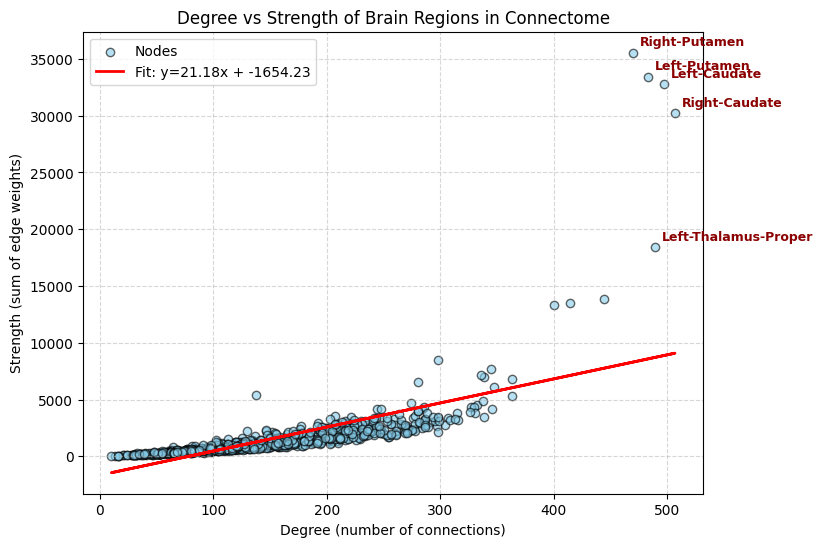

In [7]:
# Create degree and strength arrays directly from the graph
degrees = np.array([deg for _, deg in G.degree()])
strengths = np.array([deg for _, deg in G.degree(weight="weight")])

# Fit a linear regression line
slope, intercept = np.polyfit(degrees, strengths, 1)
line = slope * degrees + intercept

# Plot scatter + line
plt.figure(figsize=(8, 6))
plt.scatter(
    degrees, strengths, alpha=0.6, color="skyblue", edgecolor="k", label="Nodes"
)
plt.plot(
    degrees,
    line,
    color="red",
    linewidth=2,
    label=f"Fit: y={slope:.2f}x + {intercept:.2f}",
)
plt.xlabel("Degree (number of connections)")
plt.ylabel("Strength (sum of edge weights)")
plt.title("Degree vs Strength of Brain Regions in Connectome")
plt.legend()

# Annotate top nodes by strength with names
top_n = 5
top_nodes = sorted(G.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:top_n]

for node, strength in top_nodes:

    degree = G.degree(node)

    # Assuming you stored the name as a node attribute earlier:
    name = G.nodes[node].get("name", str(node))

    plt.annotate(
        name,
        xy=(degree, strength),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        color="darkred",
    )

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

1. Slope of 21.18

• The slope describes how strength grows with degree. Here, the slope means that, on average, each additional connection a node has contributes about 21 units of strength.

• Since strength is the sum of `n/L` over all edges, this roughly indicates that more connected regions tend to have proportionally stronger connections.

2. Bottom-left cluster

• Most nodes cluster at low degree and low strength, meaning most brain regions in this dataset are sparsely connected and their connections are relatively weak.

3. Outliers in top-right

• A few nodes, like the Putamen, Caudate, Thalamus, stand out as hubs. They have high degree (connected to many regions), and they have high strength (those connections are relatively strong).

• Biologically, these are subcortical structures involved in motor control, reward, and information integration, so it makes sense they are highly connected.

4. Correlation between degree and strength

Deviations from the fit describes something interesting:

• Above the line: fewer connections, but stronger per connection (specialized “strong links”)

• Below the line: many connections, but weaker per connection (broadly connected but weakly)

## Centrality measures

Degree, betweenness, closeness, and eigenvector centrality each capture a different notion of importance within the connectome. Degree centrality reflects the quantity of connections a region has, identifying structurally well-connected areas. Betweenness centrality measures control over information flow by highlighting regions that act as bridges along shortest paths between other nodes. Closeness centrality captures global efficiency, indicating which regions are positioned to quickly communicate with the rest of the network. Finally, eigenvector centrality measures influence by assigning higher importance to regions connected to other highly connected nodes, helping reveal the network’s structural core. Together, these complementary metrics provide a more complete picture of how brain regions support both local connectivity and large-scale communication.

In [8]:
# Compute degree centrality (0-1) and find top nodes

deg_cent = nx.degree_centrality(G)
top_deg_cent = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]

for node, val in top_deg_cent:
    name = G.nodes[node].get("name", str(node))
    print(f"Node {node} ({name}): degree centrality = {val:.3f}")

Node 503 (Right-Caudate): degree centrality = 0.500
Node 1009 (Left-Caudate): degree centrality = 0.490
Node 1008 (Left-Thalamus-Proper): degree centrality = 0.482
Node 1010 (Left-Putamen): degree centrality = 0.476
Node 504 (Right-Putamen): degree centrality = 0.464
Node 502 (Right-Thalamus-Proper): degree centrality = 0.438
Node 507 (Right-Hippocampus): degree centrality = 0.408
Node 1013 (Left-Hippocampus): degree centrality = 0.394
Node 1011 (Left-Pallidum): degree centrality = 0.358
Node 770 (lh.superiorparietal_25): degree centrality = 0.358


In [9]:
# Compute betweenness centrality and find top nodes

bet_cent = nx.betweenness_centrality(G, weight="weight")
top_bet_cent = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:10]

for node, val in top_bet_cent:
    name = G.nodes[node].get("name", str(node))
    print(f"Node {node} ({name}): betweenness centrality = {val:.3f}")

Node 502 (Right-Thalamus-Proper): betweenness centrality = 0.049
Node 1008 (Left-Thalamus-Proper): betweenness centrality = 0.041
Node 696 (lh.caudalanteriorcingulate_2): betweenness centrality = 0.040
Node 1015 (Brain-Stem): betweenness centrality = 0.033
Node 1009 (Left-Caudate): betweenness centrality = 0.031
Node 503 (Right-Caudate): betweenness centrality = 0.029
Node 188 (rh.caudalanteriorcingulate_3): betweenness centrality = 0.025
Node 203 (rh.isthmuscingulate_5): betweenness centrality = 0.024
Node 711 (lh.isthmuscingulate_5): betweenness centrality = 0.022
Node 202 (rh.isthmuscingulate_4): betweenness centrality = 0.022


In [10]:
# Compute closeness centrality (using inverse of weight as distance) and find top nodes

for u, v, d in G.edges(data=True):
    d["distance"] = 1 / d["weight"]

clo_cent = nx.closeness_centrality(G, distance="distance")
top_clo_cent = sorted(clo_cent.items(), key=lambda x: x[1], reverse=True)[:10]

for node, val in top_clo_cent:
    name = G.nodes[node].get("name", str(node))
    print(f"Node {node} ({name}): closeness centrality = {val:.3f}")

Node 503 (Right-Caudate): closeness centrality = 26.489
Node 1009 (Left-Caudate): closeness centrality = 26.489
Node 504 (Right-Putamen): closeness centrality = 26.425
Node 1010 (Left-Putamen): closeness centrality = 26.411
Node 1008 (Left-Thalamus-Proper): closeness centrality = 26.262
Node 505 (Right-Pallidum): closeness centrality = 26.220
Node 1011 (Left-Pallidum): closeness centrality = 26.185
Node 502 (Right-Thalamus-Proper): closeness centrality = 26.145
Node 159 (rh.precentral_7): closeness centrality = 26.078
Node 1013 (Left-Hippocampus): closeness centrality = 26.070


In [11]:
# Compute eigenvector centrality iteratively

eig_cent = nx.eigenvector_centrality(G, max_iter=1000, weight="weight")
top_eig_nodes = sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:10]

for node, cent in top_eig_nodes:
    name = G.nodes[node].get("name", str(node))
    print(f"Node {node} ({name}): eigenvector centrality = {cent:.4f}")

Node 1009 (Left-Caudate): eigenvector centrality = 0.5878
Node 503 (Right-Caudate): eigenvector centrality = 0.5850
Node 1010 (Left-Putamen): eigenvector centrality = 0.2467
Node 504 (Right-Putamen): eigenvector centrality = 0.2420
Node 1008 (Left-Thalamus-Proper): eigenvector centrality = 0.1848
Node 505 (Right-Pallidum): eigenvector centrality = 0.1606
Node 502 (Right-Thalamus-Proper): eigenvector centrality = 0.1452
Node 1011 (Left-Pallidum): eigenvector centrality = 0.1406
Node 507 (Right-Hippocampus): eigenvector centrality = 0.0937
Node 1013 (Left-Hippocampus): eigenvector centrality = 0.0833


Across multiple centrality measures, subcortical regions — particularly the caudate, putamen, and thalamus — emerge as key hubs in this population-level connectome. Degree centrality highlights regions with the most direct connections, showing the caudate and putamen as highly connected nodes. Betweenness centrality emphasizes nodes controlling information flow, with the thalamus and cingulate cortex facilitating communication across the network. Closeness centrality, reflecting global efficiency, again identifies the caudate and putamen as centrally positioned for rapid access to other regions. Finally, eigenvector centrality, which weights connections by the importance of neighbors, underscores the left and right caudate as influential hubs linked to other well-connected regions. Overall, these metrics consistently point to the basal ganglia and thalamus as central organizers of structural connectivity in the human brain.

## Global Network Organization

The final section explores the organizational properties of the brain network using a variety of graph-theoretic measures. Community detection identifies clusters of regions that are more densely connected to each other than to the rest of the brain. Global and local efficiency quantify how effectively information can be transmitted across the network as a whole and within local neighborhoods, highlighting both integration and segregation. Assortativity measures whether regions with many connections tend to link to other highly connected regions, providing insight into the network’s hierarchical or hub-like structure. Finally, shortest path measures capture the minimal steps needed to travel between regions, offering a sense of communication efficiency and potential bottlenecks. Together, these analyses help characterize both the large-scale architecture and the functional roles of individual nodes within the connectome.

In [12]:
print("Detecting communities using degree.")

communities = nx.community.greedy_modularity_communities(G)
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {len(comm)} nodes")

print("Detecting communities using edge weight.")

communities = nx.community.greedy_modularity_communities(G, weight="weight")
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {len(comm)} nodes")


Detecting communities using degree.
Community 1: 508 nodes
Community 2: 507 nodes
Detecting communities using edge weight.
Community 1: 330 nodes
Community 2: 326 nodes
Community 3: 189 nodes
Community 4: 170 nodes


Inspecting the communities reveals that grouping by degree (number of connections) separates the two hemispheres while using edge strength (incorporating connection intensity) reveals finer modular structures beyond just hemispheric division.

In [13]:
# Weighted adjacency matrix
W = nx.to_numpy_array(G, weight='weight')

# Global efficiency of your network
E = bct.efficiency_wei(W)

# Global efficiency of a fully connected network with the same weights but 
# missing edges replaced by max weight
W_max = W.copy()
W_max[W_max == 0] = np.max(W)  
E_max = bct.efficiency_wei(W_max)

# Normalized efficiency
E_norm = E / E_max
print(f"Normalized global efficiency: {E_norm:.3f}")

Normalized global efficiency: 0.003


Global efficiency is the average of the inverse shortest path length, quantifying how efficiently information is exchanged over the network. This code normalizes global efficiency using the max observed weights for all missing edges, which gives a feasible “fully connected” scenario. The result indicates that only a small fraction of the ideal efficiency is achieved in this connectome, reflecting the natural sparsity and heterogeneity of brain connectivity. Without a comparison (such as between healthy and diseased populations) this value does not have absolute meaning on its own, but it is still an interesting summary metric.

In [14]:
degree_assortativity = nx.degree_pearson_correlation_coefficient(G)
print(f"Degree assortativity (unweighted): {degree_assortativity:.3f}")

Degree assortativity (unweighted): 0.014


Degree assortativity measures the tendency [-1,1] of nodes to connect to other nodes with dissimilar or similar degree. The result of 0.014 is very close to 0, so in this connectome, nodes do not strongly prefer to connect to nodes with similar or dissimilar degree. This is typical for large-scale brain networks.

In [15]:
C_obs = nx.average_clustering(G, weight='weight')
L_obs = nx.average_shortest_path_length(G, weight='weight')

print(f"Observed average clustering: {C_obs:.3f}")
print(f"Observed average path length: {L_obs:.3f}")

# Generate a comparable random graph by preserving degree sequence, then
# Convert to simple graph by removing self-loops
degree_seq = [d for n, d in G.degree()]
G_rand = nx.configuration_model(degree_seq)
G_rand = nx.Graph(G_rand)
G_rand.remove_edges_from(nx.selfloop_edges(G_rand))

C_rand = nx.average_clustering(G_rand)
L_rand = nx.average_shortest_path_length(G_rand)

print(f"Random graph clustering: {C_rand:.3f}")
print(f"Random graph path length: {L_rand:.3f}")

sigma = (C_obs / C_rand) / (L_obs / L_rand)
print(f"Small-worldness (sigma): {sigma:.3f}")

Observed average clustering: 0.001
Observed average path length: 3.913
Random graph clustering: 0.193
Random graph path length: 1.875
Small-worldness (sigma): 0.002


Small-worldness quantifies how well a network balances local clustering with global efficiency. In brain connectomes, high small-worldness indicates that regions form tightly connected modules while still allowing rapid long-range communication, supporting both specialized processing and integrated brain function. A very low value (e.g., 0.002) suggests the network does not strongly exhibit small-world organization, which may reflect data weighting schemes or my processing errors/choices rather than the biology itself. Like other global measures, small-worldness is most informative when compared across conditions or groups rather than interpreted in isolation.